# transfer spatial domain from GBM dataset (using pre-trained model)

### Pre-trained models required for transfer spatial domains by SCANVI: https://doi.org/10.5281/zenodo.15699049

### Using this pre-trained model requires the data to include all genes listed in the varlist_intersection.txt file.

### If the above conditions are not met, please run Transfer_spatial_domains_by_SCANVI.ipynb.

In [ ]:
# scanpy scarches squidpy, must be loaded

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import scarches as sca
import torch
from scipy.sparse import csr_matrix

 captum (see https://github.com/pytorch/captum).


In [2]:
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load target adata for prediction
target_adata_raw = sc.read_h5ad('./GBM_data/P137_A1.h5ad')
target_adata_raw.var_names_make_unique()
target_adata_raw.obs['slide'] = 'target'
# smooth target adata
sq.gr.spatial_neighbors(target_adata_raw, coord_type="grid")
conn = target_adata_raw.obsp['spatial_connectivities']
X = target_adata_raw.X
if not isinstance(X, np.ndarray):
    X = X.toarray()
neighbor_sum = conn @ X
n_neighbors = np.array(conn.sum(axis=1)).flatten()
n_neighbors_safe = np.where(n_neighbors == 0, 1, n_neighbors)
neighbor_mean = neighbor_sum / n_neighbors_safe[:, None]
X_smoothed = 0.6 * X + 0.4 * neighbor_mean
target_adata_raw.X = csr_matrix(X_smoothed)

In [4]:
with open('varlist_intersection.txt', 'r') as f:
    varlist_intersection = [line.strip() for line in f]
print(f"overlap gene num: {len(varlist_intersection)}")
target_adata = target_adata_raw[:,varlist_intersection].copy()

overlap gene num: 16306


In [5]:
savekey = 'spatial_domain' in target_adata.obs.columns
if savekey:
    tmp_obs = target_adata.obs['spatial_domain']
target_adata.obs['spatial_domain'] = "Unknown"

In [6]:
# load model from file
ref_path = f'./ref_model/'
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []

INFO     File ./ref_model/model.pt already downloaded                                                              


In [7]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 100/100: 100%|██████████| 100/100 [28:31<00:00, 17.22s/it, v_num=1, train_loss_step=6.23e+3, train_loss_epoch=8.18e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [28:31<00:00, 17.12s/it, v_num=1, train_loss_step=6.23e+3, train_loss_epoch=8.18e+3]


In [8]:
if savekey:
    target_adata.obs['spatial_domain'] = tmp_obs
target_adata.obs['predict_SD'] = model.predict()

In [9]:
domain_color_dict = {'SD-8':'#AFB4B7','SD-9':'#6A6A6A',
                     'SD-2':'#762A86','SD-6':'#982581',
                     'SD-3':'#B43826','SD-5':'#81C08F',
                     'SD-4':'#5DB998','SD-7':'#FA6E47',
                     'SD-0':'#F4A947','SD-1':'#F98847'}

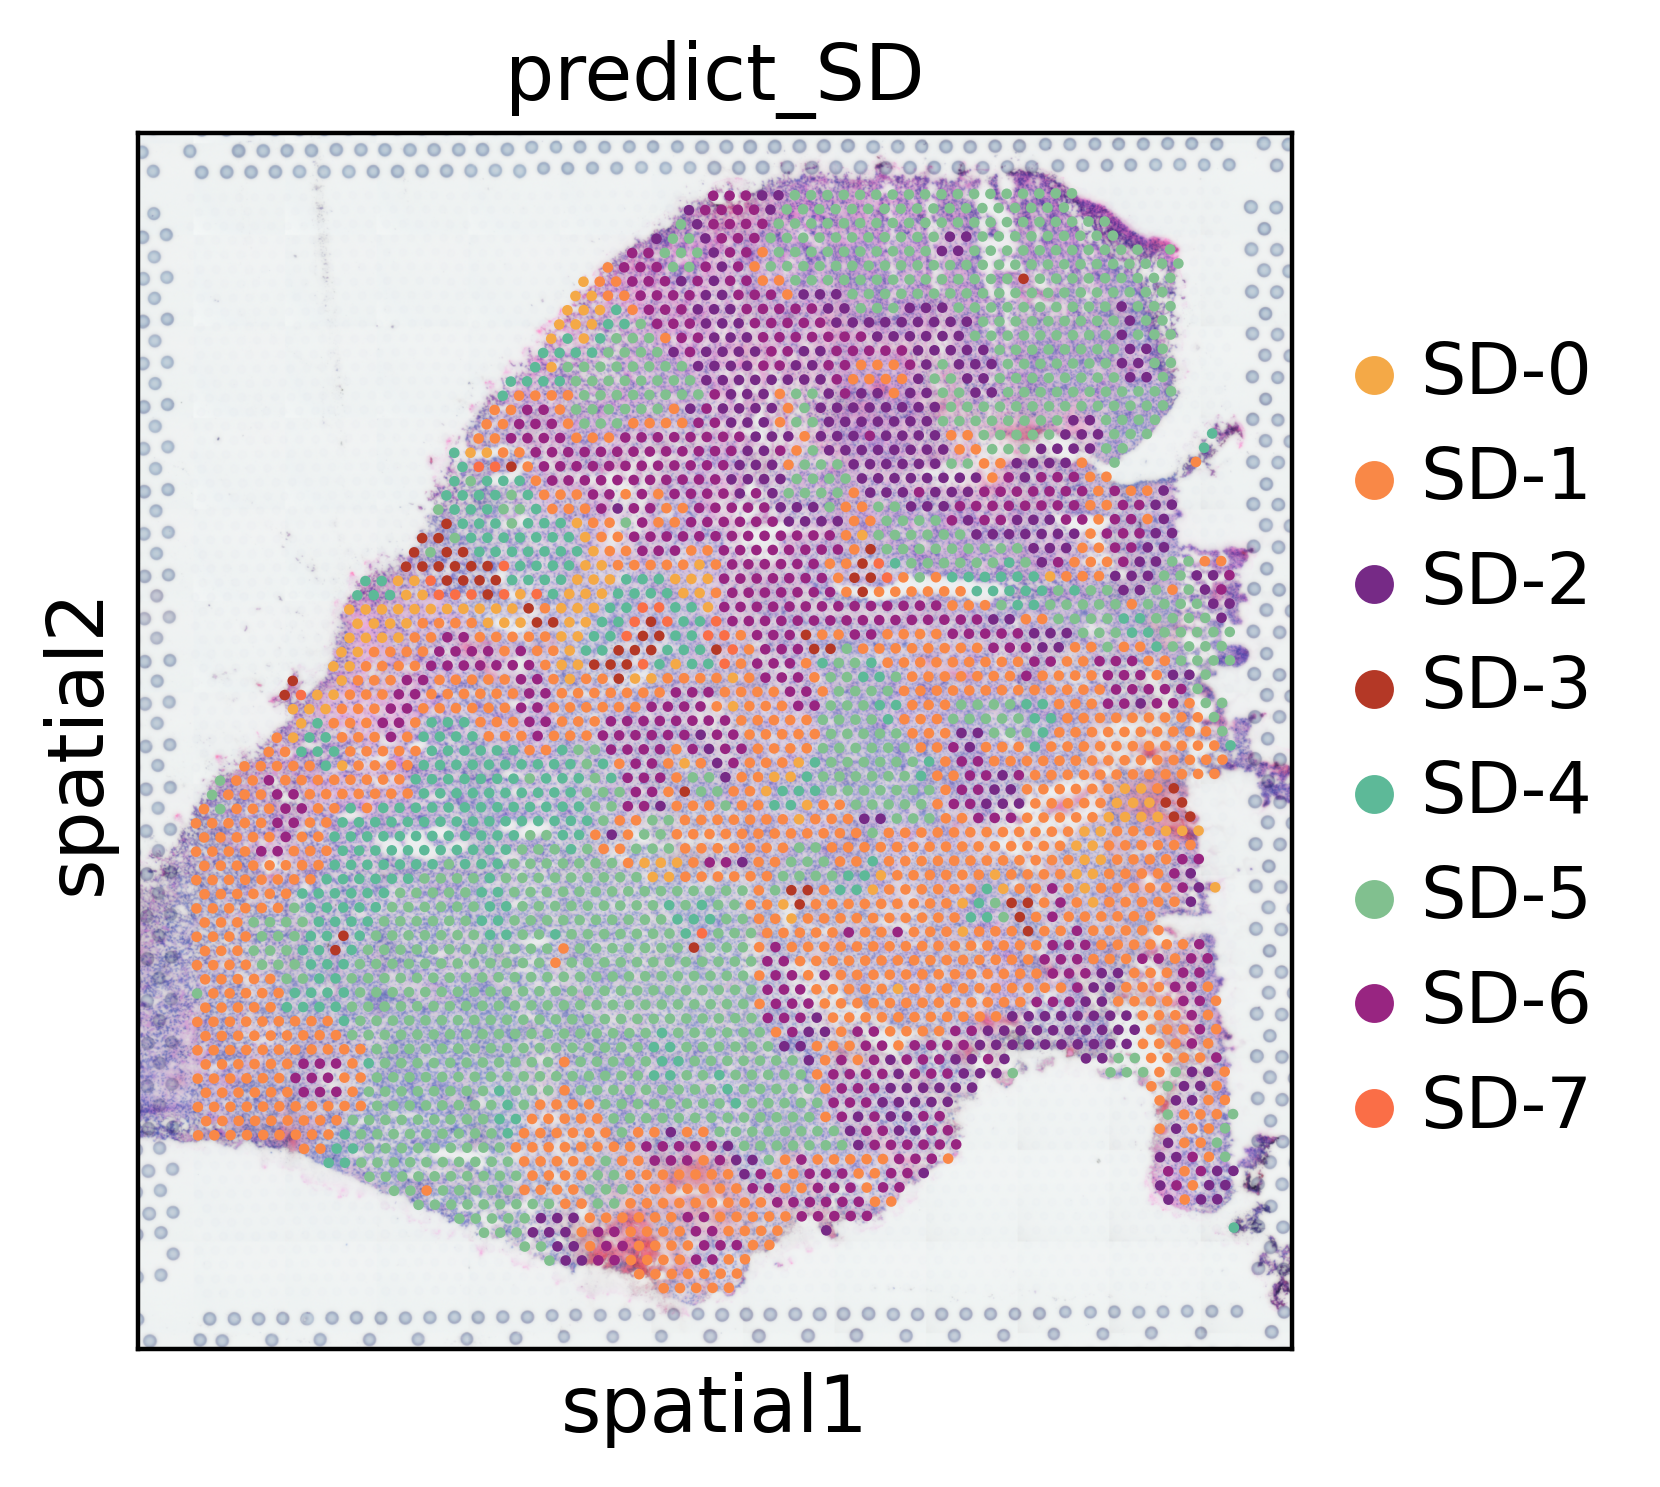

In [10]:
sc.pl.spatial(target_adata, color='predict_SD', palette=domain_color_dict)

In [11]:
if not os.path.exists(f"./output"):
    os.makedirs(f"./output")
target_adata.write_h5ad(f'./output/adata_predict_SD.h5ad')